In [1]:
import Load_Downsize_SaveAsH5 as cvt

import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './ourdata/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
#ratio=[.25,.25,.25,.25,1]
size=100
seed=42


In [6]:
cvt.LoadTransSave(filePath,features, labels, size=size, seed=seed, ratio = None)

### prepare data

In [3]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
        
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    
    mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= 100:                                               # skip when excess 100 particles
            continue
        
        mask[cIndex] = [1]  # no mask for now
            
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((100,1)), np.zeros((100,len(features_list))), np.zeros((100,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total

def separatedata(Data,y,rateval,ratetest):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest)
    N=int(len(X_ind)*rateval/(rateval+ratetest))
    X_val, X_test = X_ind[:N], X_ind[N:]
    y_val, y_test = y_ind[:N], y_ind[N:]
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

In [4]:
h5Path = "ourdata/data_100jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (100, 1) (100, 2) (100, 8)


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25)

In [6]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [7]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net(num_classes, input_shapes)

In [8]:
batch_size = 1024
epochs = 100

In [9]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [10]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True)
model.evaluate(X_test,  y_test, verbose=2)

Train on 238 samples, validate on 119 samples
Epoch 1/100
238/238 [==============================] - 6s 26ms/sample - loss: 1.6419 - accuracy: 0.1471 - val_loss: 1.5901 - val_accuracy: 0.2185
Epoch 2/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.6272 - accuracy: 0.1765 - val_loss: 1.5885 - val_accuracy: 0.2185
Epoch 3/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.5939 - accuracy: 0.1891 - val_loss: 1.5908 - val_accuracy: 0.2185
Epoch 4/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.5825 - accuracy: 0.2311 - val_loss: 1.5931 - val_accuracy: 0.2269
Epoch 5/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.5509 - accuracy: 0.2689 - val_loss: 1.5949 - val_accuracy: 0.2101
Epoch 6/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.5318 - accuracy: 0.3025 - val_loss: 1.5962 - val_accuracy: 0.2269
Epoch 7/100
238/238 [==============================] - 1s 3ms/sample - loss: 1.5063

Epoch 57/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9992 - accuracy: 0.6597 - val_loss: 1.6274 - val_accuracy: 0.1849
Epoch 58/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9980 - accuracy: 0.6639 - val_loss: 1.6284 - val_accuracy: 0.1849
Epoch 59/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9783 - accuracy: 0.6597 - val_loss: 1.6294 - val_accuracy: 0.1849
Epoch 60/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9842 - accuracy: 0.6513 - val_loss: 1.6304 - val_accuracy: 0.1849
Epoch 61/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9712 - accuracy: 0.6555 - val_loss: 1.6314 - val_accuracy: 0.1849
Epoch 62/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9642 - accuracy: 0.6597 - val_loss: 1.6325 - val_accuracy: 0.1765
Epoch 63/100
238/238 [==============================] - 1s 3ms/sample - loss: 0.9446 - accuracy: 0.7017 - val_loss: 1.6336 -

[1.670651364326477, 0.18333334]

Text(0.25, 0.9, 'Particle_lite')

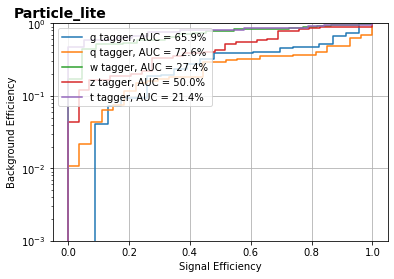

In [11]:
predict_test = model.predict(X_test)
predict_test = predict_test.transpose((1,0))
y_test = y_test.transpose((1,0))
labels = ['g','q','w','z','t']
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[i]
    df[label + '_pred'] = predict_test[i]
    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
    auc1[label] = auc(fpr[label], tpr[label])
    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.legend(loc='upper left')
plt.ylim(0.001,1)
plt.grid(True)

plt.figtext(0.25, 0.90,'Particle_lite',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

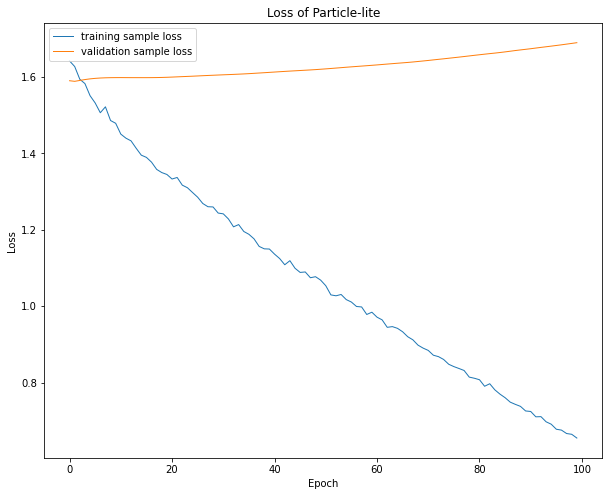

In [12]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'particle net ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

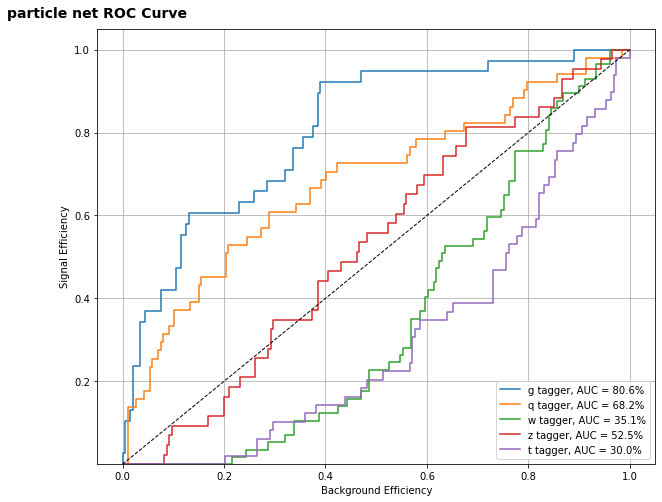

In [14]:
y_pred = makeRoc(X_train, y_train,labels, model, outputSuffix='particle net') 